## Marker SNPs in __An. arabiensis__

To start - create a folder `data/` in your working directory and move your VCFs to the following subfolders.

```
data/
    ara_small/
        AgamP4_2L.DNAseq.SNPs.filtered.vcf
        ...
    gam_g3_pooled/
        AgamP4_2L.DNAseq.SNPs.filtered.vcf
        ...
    hyb_rnaseq/
        AgamP4_2L.RNAseq.SNPs.filtered.vcf
        ...
```

VCFs have the same name, but they contain data from different samples.

After this, we will need to transform VCF files to Zarr storage so we can load the data using `allel` and `sgkit`

In [33]:
# import packages
import sgkit as sg
import pandas as pd
import numpy as np
import zarr
import xarray as xr
import allel


First, we need to create gzipped VCF files and index them with `tabix`. Go to your terminal and activate your conda environment and run `bash _create_tbi.sh`.

In [246]:
# bash _create_tbi.sh

To work `sgkit` we need to save the VCF to Zarr storage

In [254]:
# Fields to import from VCF
format_fields = ["FORMAT/AD",
                 "FORMAT/DP",
                 "FORMAT/GT",
                 "FORMAT/GQ"]

info_fields = ["INFO/AC",
               "INFO/DP",
               "INFO/MQ"]

In [255]:
import os
import glob
from sgkit.io.vcf import vcf_to_zarr

# takes about 25 min
vcfs = glob.glob("data/**/*vcf.gz")
for vcf in vcfs:
    filename = os.path.basename(vcf)
    path = os.path.dirname(vcf)
    contig = filename.split('.')[0]

    if contig in ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R', 'AgamP4_X']:
        save_path = os.path.join(path, contig, f'{contig}.zarr')
        vcf_to_zarr(vcf, save_path, tempdir='_tmp', 
            fields=format_fields + info_fields,
            field_defs={"FORMAT/AD": {"Number": "R"}})

/Users/nace/opt/miniconda3/envs/wiggle/lib/python3.8/site-packages/sgkit/io/vcf/vcf_reader.py:893: MaxAltAllelesExceededWarning: Some alternate alleles were dropped, since actual max value 4 exceeded max_alt_alleles setting of 3.
  warnings.warn(
/Users/nace/opt/miniconda3/envs/wiggle/lib/python3.8/site-packages/sgkit/io/vcf/vcf_reader.py:893: MaxAltAllelesExceededWarning: Some alternate alleles were dropped, since actual max value 4 exceeded max_alt_alleles setting of 3.
  warnings.warn(
/Users/nace/opt/miniconda3/envs/wiggle/lib/python3.8/site-packages/sgkit/io/vcf/vcf_reader.py:893: MaxAltAllelesExceededWarning: Some alternate alleles were dropped, since actual max value 4 exceeded max_alt_alleles setting of 3.
  warnings.warn(


Concatenate all zarr stores into a single zarr store that will contain all contigs

In [318]:
from sgkit.io.vcf import concat_zarrs

zarrs = glob.glob("data/ara_small/**/*.zarr")
concat_zarrs(zarrs, output='dataset/ara_small.snp.zarr')

zarrs = glob.glob("data/gam_g3_pooled/**/*.zarr")
concat_zarrs(zarrs, output='dataset/gam_g3_pooled.snp.zarr')

zarrs = glob.glob("data/hyb_rnaseq/**/*.zarr")
concat_zarrs(zarrs, output='dataset/hyb_rnaseq.snp.zarr')

After creating a zarr storage we can load it into an xarray dataset with `sgkit.load_dataset()`.

In [34]:
# load dataset
z = zarr.open_consolidated('dataset/ara_small.snp.zarr')
ds = sg.load_dataset('dataset/ara_small.snp.zarr')

# maps contig names to contig indices stored in `variant_contig` 
ds["variant_contig_name"] = (["variants"], [ds.contigs[contig] for contig in ds["variant_contig"].values])

Let's have a look what our dataset `ds` contains

In [35]:
ds

<xarray.Dataset>
Dimensions:               (variants: 5202171, samples: 2, alleles: 4,
                           ploidy: 2, alt_alleles: 3)
Dimensions without coordinates: variants, samples, alleles, ploidy, alt_alleles
Data variables: (12/16)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 2, 4), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 2), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 2), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 2, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 2, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 2), meta=np.ndarray>
    ...                    ...
    variant_allele        (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig        (variants) int16 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name   (variants) <U9 'AgamP4_X' 'AgamP4_X' ... 'AgamP4_2R'
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  3
    source:                sgkit-0.4.0

We can see that we have many data variables - some starting with `call_` that describe called genotypes and some with `variant_` that describe variants (per genomic position). We also have a variable `sample_id` describing samples in the dataset.

Since `variant_position` does not directly align with the index of the dataset, we need a function that will find indices of variants based on their `variant_position` for a given genomic location. 

The following functions were obtained from https://github.com/tomwhite/sgkit/blob/select/sgkit/indexing.py


In [268]:
from typing import Any, List, Optional, Sequence, Union

import numpy as np
import xarray as xr


def pslice_to_indexer(
    ds: xr.Dataset,
    contig: Union[None, str, Sequence[Optional[str]]] = None,
    start: Union[None, int, Sequence[Optional[int]]] = None,
    end: Union[None, int, Sequence[Optional[int]]] = None,
) -> Any:
    """Convert a genomic position slice (or slices) to an Xarray indexer for selecting variants.
    Parameters
    ----------
    ds
        Genotype call dataset.
    contig
        A single contig, or a sequence of contigs. If None and there is only one contig in the dataset then
        that contig will be assumed.
    start
        A single start position, or a sequence of start positions. Start positions are inclusive, following Python semantics.
        A start position of None means start of contig.
    end
        A single end position, or a sequence of end positions. End positions are exclusive, following Python semantics.
        An end position of None means end of contig.
    Returns
    -------
    An Xarray indexer suitable for indexing the dataset using :meth:`xarray.Dataset.isel` with a ``variants`` dimension key.
    Warnings
    --------
    The end position of indels are *not* considered, so the behavior is more
    like the bcftools ``--targets`` option (which only considers start position)
    than the ``--regions`` option (which considers overlaps).
    Examples
    --------
    >>> import sgkit as sg
    >>> ds = sg.simulate_genotype_call_dataset(n_variant=10, n_sample=2, n_contig=2)
    >>> ds.isel(dict(variants=sg.pslice_to_indexer(ds, "0"))) # doctest: +SKIP
    <xarray.Dataset>
    Dimensions:             (variants: 5, alleles: 2, samples: 2, ploidy: 2)
    Dimensions without coordinates: variants, alleles, samples, ploidy
    Data variables:
        variant_contig      (variants) int64 0 0 0 0 0
        variant_position    (variants) int64 0 1 2 3 4
        variant_allele      (variants, alleles) |S1 b'C' b'G' b'A' ... b'G' b'C'
        sample_id           (samples) <U2 'S0' 'S1'
        call_genotype       (variants, samples, ploidy) int8 0 0 1 0 1 ... 0 1 1 0 0
        call_genotype_mask  (variants, samples, ploidy) bool False False ... False
    >>> ds.isel(dict(variants=sg.pslice_to_indexer(ds, contigs=("0", "1"), starts=(2, 3), ends=(4, None)))) # doctest: +SKIP
    <xarray.Dataset>
    Dimensions:             (variants: 4, alleles: 2, samples: 2, ploidy: 2)
    Dimensions without coordinates: variants, alleles, samples, ploidy
    Data variables:
        variant_contig      (variants) int64 0 0 1 1
        variant_position    (variants) int64 2 3 3 4
        variant_allele      (variants, alleles) |S1 b'G' b'A' b'A' ... b'C' b'A'
        sample_id           (samples) <U2 'S0' 'S1'
        call_genotype       (variants, samples, ploidy) int8 1 0 0 1 0 ... 0 1 0 1 1
        call_genotype_mask  (variants, samples, ploidy) bool False False ... False
    """
    size = ds.dims["variants"]
    all_contigs = ds.attrs["contigs"]
    variant_contig = ds.variant_contig.values
    variant_position = ds.variant_position.values

    if contig is None:
        if len(all_contigs) != 1:
            raise ValueError("Contig must specified when dataset has multiple contigs.")

        # TODO: improve type checks
        if (
            (start is None and end is None)
            or isinstance(start, int)
            or isinstance(end, int)
        ):
            contig = all_contigs[0]
        else:
            if start is not None:
                n = len(start)
            elif end is not None:
                n = len(end)
            contig = [all_contigs[0]] * n

    # TODO: check contigs, starts, ends are all the same length (with some caveats - e.g. if on one contig)

    if (
        isinstance(contig, str)
        and (start is None or isinstance(start, int))
        and (end is None or isinstance(end, int))
    ):
        # assume single for the moment
        slice = _pslice_to_slice(
            all_contigs, variant_contig, variant_position, contig, start, end
        )
        return slice
    else:
        slices = [
            _pslice_to_slice(all_contigs, variant_contig, variant_position, c, s, e)
            for (c, s, e) in zip(contig, start, end)
        ]
        return np.concatenate([np.arange(*sl.indices(size)) for sl in slices])  # type: ignore[no-untyped-call]


def _pslice_to_slice(
    all_contigs: List[str],
    variant_contig: Any,
    variant_position: Any,
    contig: str,
    start: Optional[int] = None,
    end: Optional[int] = None,
) -> slice:

    contig_index = all_contigs.index(contig)
    contig_range = np.searchsorted(variant_contig, [contig_index, contig_index + 1])

    if start is None and end is None:
        start_index, end_index = contig_range
    else:
        contig_pos = variant_position[slice(contig_range[0], contig_range[1])]
        if start is None:
            start_index = contig_range[0]
            end_index = contig_range[0] + np.searchsorted(contig_pos, [end])[0]
        elif end is None:
            start_index = contig_range[0] + np.searchsorted(contig_pos, [start])[0]
            end_index = contig_range[1]
        else:
            start_index, end_index = contig_range[0] + np.searchsorted(
                contig_pos, [start, end]
            )

    return slice(start_index, end_index)

We can now use `pslice_to_indexer` to subset the dataset only for a given genomic region (e.g. 2L:300-500)

In [269]:
ds.isel(dict(variants=pslice_to_indexer(ds, "AgamP4_2L", 300, 500)))

<xarray.Dataset>
Dimensions:               (variants: 3, samples: 2, alleles: 4, ploidy: 2,
                           alt_alleles: 3)
Dimensions without coordinates: variants, samples, alleles, ploidy, alt_alleles
Data variables: (12/16)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(3, 2, 4), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(3, 2), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(3, 2), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(3, 2, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(3, 2, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(3, 2), meta=np.ndarray>
    ...                    ...
    variant_allele        (variants, alleles) object dask.array<chunksize=(3, 4), meta=np.ndarray>
    variant_contig        (variants) int16 dask.array<chunksize=(3,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(3,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(3,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(3,), meta=np.ndarray>
    variant_contig_name   (variants) <U9 'AgamP4_X' 'AgamP4_X' 'AgamP4_X'
Attributes: (3)

`.isel()` subsets the dataset successfully which now contains only 3 variants

In [324]:
ds['variant_position'][:10].compute()

<xarray.DataArray 'variant_position' (variants: 10)>
dask.array<getitem, shape=(10,), dtype=int32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    variant_is_hom_alt_fixed  (variants) bool dask.array<chunksize=(10,), meta=np.ndarray>
Dimensions without coordinates: variants
Attributes: (1)

### Marker SNPs

Marker SNPs are going to be all homozygous alternative alleles in An. arabiensis. 

In [38]:
# add sample stats to the dataset
ds = sg.sample_stats(ds)

ds

<xarray.Dataset>
Dimensions:               (samples: 2, variants: 5202171, alleles: 4,
                           ploidy: 2, alt_alleles: 3)
Dimensions without coordinates: samples, variants, alleles, ploidy, alt_alleles
Data variables: (12/22)
    sample_n_called       (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_call_rate      (samples) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_het          (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_hom_ref      (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_hom_alt      (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_non_ref      (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_allele        (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig        (variants) int16 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name   (variants) <U9 'AgamP4_X' 'AgamP4_X' ... 'AgamP4_2R'
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  3
    source:                sgkit-0.4.0

In [39]:
# use .compute() to access the data in the array
ds['call_genotype'][:10].compute()

<xarray.DataArray 'call_genotype' (variants: 10, samples: 2, ploidy: 2)>
array([[[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1]]], dtype=int8)
Dimensions without coordinates: variants, samples, ploidy
Attributes:
    comment:       Call genotype. Encoded as allele values (0 for the referen...
    mixed_ploidy:  False

In [40]:
G =  ds['call_genotype']
is_hom_alt_fixed = ((G > 0) & (G[..., 0] == G)).all(dim="ploidy").all(dim="samples")

ds['variant_is_hom_alt_fixed'] = is_hom_alt_fixed

In [41]:
is_hom_alt_fixed[:10].compute()

<xarray.DataArray 'call_genotype' (variants: 10)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])
Dimensions without coordinates: variants

In [42]:
ds = ds.set_coords(['variant_is_hom_alt_fixed'])
ds

<xarray.Dataset>
Dimensions:                   (samples: 2, variants: 5202171, alleles: 4,
                               ploidy: 2, alt_alleles: 3)
Coordinates:
    variant_is_hom_alt_fixed  (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
Dimensions without coordinates: samples, variants, alleles, ploidy, alt_alleles
Data variables: (12/22)
    sample_n_called           (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_call_rate          (samples) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_het              (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_hom_ref          (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_hom_alt          (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_non_ref          (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    ...                        ...
    variant_allele            (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig            (variants) int16 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id                (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask           (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position          (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name       (variants) <U9 'AgamP4_X' ... 'AgamP4_2R'
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  3
    source:                sgkit-0.4.0

We can select the fixed homozyous alternate alleles for Ara

In [43]:
ds_markers = ds.isel(variants=ds.variant_is_hom_alt_fixed)
ds_markers

<xarray.Dataset>
Dimensions:                   (samples: 2, variants: 3308127, alleles: 4,
                               ploidy: 2, alt_alleles: 3)
Coordinates:
    variant_is_hom_alt_fixed  (variants) bool dask.array<chunksize=(9201,), meta=np.ndarray>
Dimensions without coordinates: samples, variants, alleles, ploidy, alt_alleles
Data variables: (12/22)
    sample_n_called           (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_call_rate          (samples) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_het              (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_hom_ref          (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_hom_alt          (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_n_non_ref          (samples) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    ...                        ...
    variant_allele            (variants, alleles) object dask.array<chunksize=(9201, 4), meta=np.ndarray>
    variant_contig            (variants) int16 dask.array<chunksize=(9201,), meta=np.ndarray>
    variant_id                (variants) object dask.array<chunksize=(9201,), meta=np.ndarray>
    variant_id_mask           (variants) bool dask.array<chunksize=(9201,), meta=np.ndarray>
    variant_position          (variants) int32 dask.array<chunksize=(9201,), meta=np.ndarray>
    variant_contig_name       (variants) <U9 'AgamP4_X' ... 'AgamP4_2R'
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  3
    source:                sgkit-0.4.0

Save the markers to a separate zarr store.

In [319]:
# ---------------- fixes a couple of bugs needed for saving -----------------------
for var in ds_markers:
    if not var.startswith('sample'):
        ds_markers[var] = ds_markers[var].chunk((10000, -1, -1))
        ds_markers[var].encoding.clear()

# save the dataset
ds_markers.to_zarr('analysis/ara_markers.zarr', mode='w', )

/Users/nace/opt/miniconda3/envs/wiggle/lib/python3.8/site-packages/xarray/conventions.py:205: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(
/Users/nace/opt/miniconda3/envs/wiggle/lib/python3.8/site-packages/xarray/conventions.py:205: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


We can also plot several different genotype attributes to gain insight into data quality etc.

/Users/nace/opt/miniconda3/envs/wiggle/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='call_DP', ylabel='Density'>

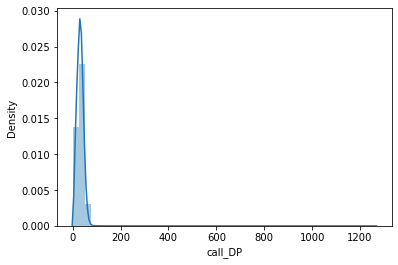

In [275]:
import seaborn as sns
%matplotlib inline

sns.distplot(ds_markers.call_DP)

We can also import genotypes to `allel` as a `GenotypeArray`

In [48]:
G = allel.GenotypeDaskArray(ds_markers['call_genotype'])
G

/Users/nace/opt/miniconda3/envs/wiggle/lib/python3.8/site-packages/dask/array/core.py:2861: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


<GenotypeDaskArray shape=(3308127, 2, 2) dtype=int8>

### Excercise
- subset the dataset `ds_markers` only to variants on `AgamP4_2L` contig. Hint: use `.isel` with `variant_contig_name` variable.
- count how many marker SNPs are on each contig.
- calculate SNP density for each contig - you can find contig lengths in `data/AgamP4.sizes`.